# T1 map calculation tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.utils.tools import convert_to_pi_range
from ukat.mapping.t1 import T1, magnitude_correct

# Ensure figures are rendered in the notebook
%matplotlib inline

D:\ProgramData\Anaconda2\envs\ukat_310_pip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\ppzajd\NextCloud\University\Renal Imaging\ukat\ukat\data\fetch.py:20: UserWarning: Pass ['md5_list'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  fetch_b0_ge = _make_fetcher('fetch_b0_ge', pjoin(ukat_home, 'b0_ge'),
D:\ppzajd\NextCloud\University\Renal Imaging\ukat\ukat\data\fetch.py:36: UserWarning: Pass ['md5_list'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  fetch_b0_philips = _make_fetcher('fetch_b0_philips',
D:\ppzajd\NextCloud\University\Renal Imaging\ukat\ukat\data\fetch.py:81: UserWarning: Pass ['md5_list'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an err

Tell python where to store the T1 maps NIfTI files we will generate. We will store it in a directory called `t1_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T1 maps
directory = 't1_calculation_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Retrieve T1 test data using our data fetcher. The first time the fetcher is run, it will download the data from the
internet, after that it will just use the cached local data.

This will return 4 variables:
* `magnitude`: a 4D array with the magnitude data at all echo times.
* `phase`: a 4D array with the phase data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `TIs`: an array containing the inversion times, in seconds.
* `tss`: the temporal slice spacing of the image.

In [3]:
# Fetch test data
magnitude, phase, affine, ti, tss = fetch.t1_philips(2)
phase = convert_to_pi_range(phase)

complex_data = magnitude * (np.cos(phase) + 1j * np.sin(phase)) # convert magnitude and phase into complex data
ti = np.array(ti) * 1000  # convert TIs to ms
tss *= 1000 # convert tss into ms

Let's look at the effects of magnitude correction by plotting the raw signal from a voxel within the kidney over the range 
of inversion times.

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in log


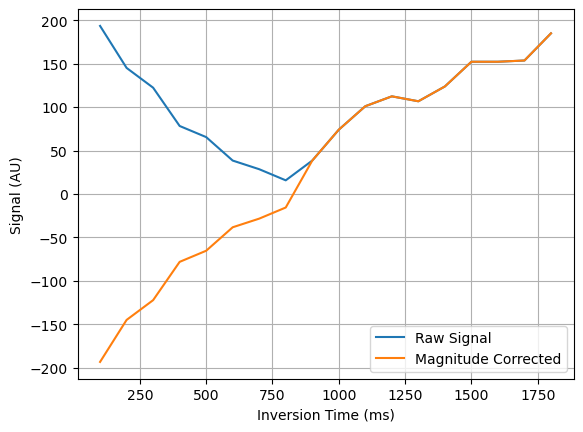

In [4]:
raw_signal = magnitude[55, 40, 2, :]
magnitude_corrected = magnitude_correct(complex_data)
magnitude_corrected_signal = magnitude_corrected[55, 40, 2, :]

plt.plot(ti, raw_signal, label='Raw Signal')
plt.plot(ti, magnitude_corrected_signal, label='Magnitude Corrected')
plt.xlabel('Inversion Time (ms)')
plt.ylabel('Signal (AU)')
plt.grid(True)
plt.legend()
plt.show()

The dynamic range of this voxel has been doubled by magnitude correcting the data. This can be used to increase the accuracy
 of our T1 maps and simplifies the equation the data is fit to by removing the absolute term. If the data has been magnitude
  corrected, don't forget to set `mag_corr=True` when creating the `T1` object.
 
Now compute the T1 maps using the `T1` class implemented in `mapping`. By default this is executed over all available CPU cores
however this can be run single-threaded by setting `multithread=False` although will obviously take much longer.

To speed things up a bit we'll just do this for the central region of the image.

In [5]:
mapper = T1(magnitude_corrected[32:-32, 32:-32, :, :], ti, affine=affine, parameters=2, tss=tss, mag_corr=True)

# Save output maps to Nifti
mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='Philips2', maps='all')

Display the T1 map.

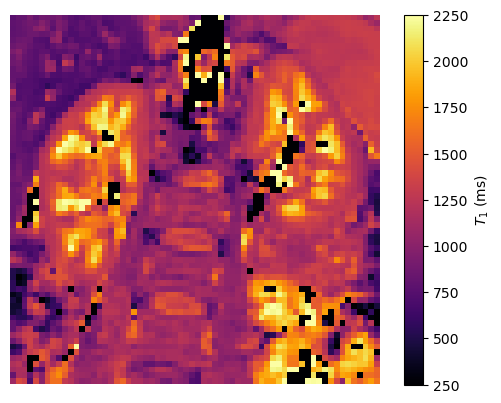

In [6]:
fig, ax1 = plt.subplots()

# Display the T1 map generated from the raw magnitude data
im = ax1.imshow(mapper.t1_map[:, :, 2].T, origin='lower', cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_1$ (ms)')
ax1.axis('off')

plt.show()

`ukat` can also process Modified Look-Locker Inversion Recovery (MOLLI) data as demonstrated below.

In [7]:
image, affine, inversion_times = fetch.t1_molli_philips()
mapper = T1(image[32:-32, 32:-32, :2, :], inversion_times * 1000, affine=affine, multithread=True, molli=True)
mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='Philips_MOLLI', maps='all')

MOLLI requires a three parameter fit, using parameters=3.
invalid value encountered in divide
invalid value encountered in divide


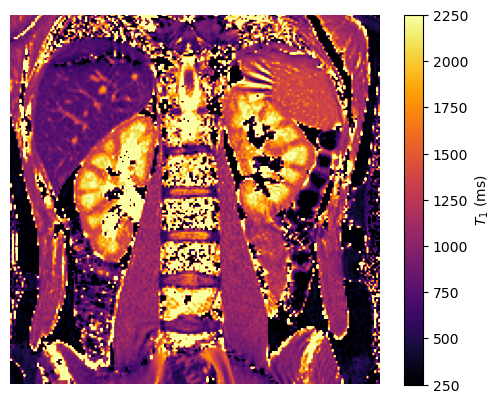

In [8]:
fig, ax1 = plt.subplots()
im = ax1.imshow(mapper.t1_map[:, :, 1].T, origin='lower', cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_1$ (ms)')
ax1.axis('off')

plt.show()

Motion artifacts can reduce the quality of T1 maps, `ukat` can correct for motion artifacts using Model Driven Registration
(MDR). This technique uses how closely a time series of voxels fits the expected model to drive a non-linear registration
i.e. here how close the signal from a voxel is to the expected T1 recovery curve. This process involves calculating multiple
T1 maps during the iterative registration process and as such takes ~5x longer than the standard T1 mapping process.

The example below demonstrates the MDR process on the SE-EPI dataset used above.

In [3]:
magnitude, phase, affine, ti, tss = fetch.t1_philips(2)
phase = convert_to_pi_range(phase)

ti = np.array(ti) * 1000  # convert TIs to ms
tss *= 1000
mapper_mdr = T1(magnitude, ti, affine, tss=tss, mdr=True)
mapper_mdr.to_nifti(output_directory=OUTPUT_DIR, base_file_name='Philips2_MDR', maps='all')

-----------------
Fitting slice 000
-----------------
Fitting signal model (iteration 1)
Fitting deformation field (iteration 1)
Deformation correction after iteration 1: 11.329011491479617 pixels
Calculation time for iteration 1: 2.6339067538579304 min
Fitting signal model (iteration 2)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.002382477501964238



Fitting deformation field (iteration 2)
Deformation correction after iteration 2: 10.85162747597274 pixels
Calculation time for iteration 2: 1.4475806434949239 min
Fitting signal model (iteration 3)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.006325044690265978



Fitting deformation field (iteration 3)
Deformation correction after iteration 3: 4.278899632013766 pixels
Calculation time for iteration 3: 1.379961093266805 min
Total calculation time: 5.461448490619659 min
-----------------
Fitting slice 001
-----------------
Fitting signal model (iteration 1)
Fitting deformation field (iteration 1)
Deformation correction after iteration 1: 9.728431950385191 pixels
Calculation time for iteration 1: 1.3656866947809856 min
Fitting signal model (iteration 2)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.007916128331739452



Fitting deformation field (iteration 2)
Deformation correction after iteration 2: 3.5468965987768946 pixels
Calculation time for iteration 2: 1.3789988478024802 min
Fitting signal model (iteration 3)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.008529990614451682



Fitting deformation field (iteration 3)
Deformation correction after iteration 3: 2.2327407313170866 pixels
Calculation time for iteration 3: 1.4029850443204244 min
Total calculation time: 4.14767058690389 min
-----------------
Fitting slice 002
-----------------
Fitting signal model (iteration 1)
Fitting deformation field (iteration 1)
Deformation correction after iteration 1: 5.946377994690266 pixels
Calculation time for iteration 1: 1.331636381149292 min
Fitting signal model (iteration 2)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.004667253014142039



Fitting deformation field (iteration 2)
Deformation correction after iteration 2: 3.6769805270999343 pixels
Calculation time for iteration 2: 1.3743356148401895 min
Fitting signal model (iteration 3)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.004370668711956944



Fitting deformation field (iteration 3)
Deformation correction after iteration 3: 2.8336751292143125 pixels
Calculation time for iteration 3: 1.383198324839274 min
Total calculation time: 4.089170320828756 min
-----------------
Fitting slice 003
-----------------
Fitting signal model (iteration 1)
Fitting deformation field (iteration 1)
Deformation correction after iteration 1: 4.572372251233986 pixels
Calculation time for iteration 1: 1.3843600789705912 min
Fitting signal model (iteration 2)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.008586322427579176



Fitting deformation field (iteration 2)
Deformation correction after iteration 2: 1.6718005873444346 pixels
Calculation time for iteration 2: 1.3563294450441996 min
Fitting signal model (iteration 3)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.00851916671970175



Fitting deformation field (iteration 3)
Deformation correction after iteration 3: 1.349992683604407 pixels
Calculation time for iteration 3: 1.359154204527537 min
Total calculation time: 4.099843728542328 min
-----------------
Fitting slice 004
-----------------
Fitting signal model (iteration 1)
Fitting deformation field (iteration 1)
Deformation correction after iteration 1: 4.034772087976726 pixels
Calculation time for iteration 1: 1.4079935073852539 min
Fitting signal model (iteration 2)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.001060464618529129



Fitting deformation field (iteration 2)
Deformation correction after iteration 2: 2.610392902849657 pixels
Calculation time for iteration 2: 1.3328100522359212 min
Fitting signal model (iteration 3)


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.005596153069360679



Fitting deformation field (iteration 3)
Deformation correction after iteration 3: 1.9996901611272677 pixels
Calculation time for iteration 3: 1.35002046028773 min
Total calculation time: 4.090824019908905 min


Negative values found in data, this could be due to noise or preprocessing steps, however if you have magnitude corrected your data, remember to set mag_corr=True
Min value = -0.012204359285533428



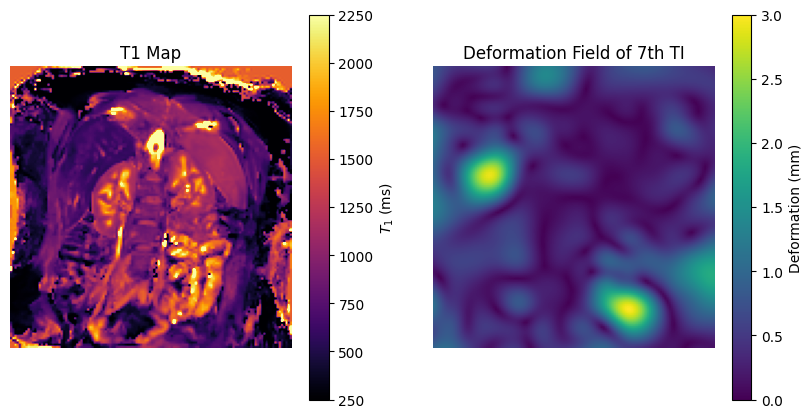

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im = ax1.imshow(mapper_mdr.t1_map[:, :, 1].T, origin='lower', cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_1$ (ms)')
ax1.axis('off')
ax1.set_title('T1 Map')

deformation_field = mapper_mdr.deformation_field
defo_norm = np.linalg.norm(deformation_field, axis=-1) / 3 # Deformation is given in units of pixel spacing. Dividing by 3
# gives the deformation in mm
max_defo_ti = np.argmax(np.mean(defo_norm, axis=(0, 1, 2)))
im = ax2.imshow(defo_norm[:, :, 1, max_defo_ti].T, origin='lower', cmap='viridis', clim=(0, 3))
cb = fig.colorbar(im, ax=ax2)
cb.set_label('Deformation (mm)')
ax2.axis('off')
ax2.set_title(f'Deformation Field of {max_defo_ti + 1}th TI')
plt.show()